In [ ]:
import os
import pandas as pd
import numpy as np
import re

def dataseq():
    sequences = {}

    folders_with_los = {
        './PeriodicAttack_vehsPerHour_1100/': 'D',
    }
    
    mobility_pattern = re.compile(r'RSUExampleScenario3\.target\[\d+\]\.veinsmobility$')
    appl_pattern = re.compile(r'RSUExampleScenario3\.target\[\d+\]\.appl$')

    for base_path, los in folders_with_los.items():
        print(f"[INFO] Processing folder {base_path} with LOS={los}")
        for dep in range(895, 906):
            folder = os.path.join(base_path, f'depart_{dep}')
            for iter_num in range(1, 31):
                file_path = os.path.join(folder, f'PeriodicAttack_depart_{dep}_iter_{iter_num}_vector.csv')
                if not os.path.exists(file_path):
                    print(f"⚠️ File not found: {file_path}")
                    continue

                try:
                    df = pd.read_csv(file_path)
                except Exception as e:
                    print(f"❌ Error reading {file_path}: {e}")
                    continue

                # Extract anomaly timestamps
                anomaly_times = set()
                anomaly_data = df[
                    (df['type'] == 'vector') &
                    (df['module'].str.match(appl_pattern)) &
                    (df['name'] == 'Target Received Messages Timestamp')
                ]
                for _, row in anomaly_data.iterrows():
                    try:
                        times = [int(float(t)) for t in row['vectime'].split()]
                        values = [int(float(v)) for v in row['vecvalue'].split()]
                        for t, v in zip(times, values):
                            if v == 1:
                                anomaly_times.add(t)
                    except Exception as e:
                        print(f"⚠️ Error parsing anomaly data in {file_path}: {e}")

                # Extract features: speed, posx, posy, acceleration
                features_data = {}
                feature_names = ['speed', 'acceleration']
                for feature in feature_names:
                    feature_rows = df[
                        (df['type'] == 'vector') &
                        (df['module'].str.match(mobility_pattern)) &
                        (df['name'] == feature)
                    ]
                    times_vals = []
                    for _, row in feature_rows.iterrows():
                        try:
                            times = [int(float(t)) for t in row['vectime'].split()]
                            vals = [float(v) for v in row['vecvalue'].split()]
                            if len(times) == len(vals):
                                times_vals.append((times, vals))
                        except Exception as e:
                            print(f"⚠️ Error parsing {feature} data in {file_path}: {e}")

                    # Merge all times/values from multiple rows for this feature
                    all_time_vals = {}
                    for t_list, v_list in times_vals:
                        for t, v in zip(t_list, v_list):
                            if t not in all_time_vals:
                                all_time_vals[t] = v
                    features_data[feature] = all_time_vals

                # Align all times across features
                all_times = set()
                for feature_dict in features_data.values():
                    all_times.update(feature_dict.keys())
                all_times = sorted(all_times)

                if not all_times:
                    print(f"⚠️ No feature data found in {file_path}")
                    continue

                # Build feature matrix (times x features)
                feature_matrix = []
                for t in all_times:
                    row = []
                    for feature in feature_names:
                        row.append(features_data[feature].get(t, 0.0))  # fill missing with 0.0
                    feature_matrix.append(row)

                # Build label vector
                labels = [1 if t in anomaly_times else 0 for t in all_times]

                sequences[(los, dep, iter_num)] = (
                    np.array(all_times, dtype=int),
                    np.array(feature_matrix, dtype=float),
                    np.array(labels, dtype=int)
                )

    if len(sequences) == 0:
        raise RuntimeError("No sequences loaded! Check your data paths and files.")

    print(f"[INFO] Loaded total sequences: {len(sequences)}")
    return sequences
sequences=dataseq()

[INFO] Processing folder ./PeriodicAttack_vehsPerHour_800/ with LOS=B
[INFO] Loaded total sequences: 330


In [14]:
# sequences = dataseq('./PeriodicAttack_vehsPerHour_500/')

# # Access data for departure 895, iteration 5
# dep, iter = 895, 5
# times, speeds, labels = sequences[(dep, iter)]

# # Get all departure numbers and iteration numbers available
available_sequences = list(sequences.keys())

In [15]:
available_sequences, len(available_sequences)

([('B', 895, 1),
  ('B', 895, 2),
  ('B', 895, 3),
  ('B', 895, 4),
  ('B', 895, 5),
  ('B', 895, 6),
  ('B', 895, 7),
  ('B', 895, 8),
  ('B', 895, 9),
  ('B', 895, 10),
  ('B', 895, 11),
  ('B', 895, 12),
  ('B', 895, 13),
  ('B', 895, 14),
  ('B', 895, 15),
  ('B', 895, 16),
  ('B', 895, 17),
  ('B', 895, 18),
  ('B', 895, 19),
  ('B', 895, 20),
  ('B', 895, 21),
  ('B', 895, 22),
  ('B', 895, 23),
  ('B', 895, 24),
  ('B', 895, 25),
  ('B', 895, 26),
  ('B', 895, 27),
  ('B', 895, 28),
  ('B', 895, 29),
  ('B', 895, 30),
  ('B', 896, 1),
  ('B', 896, 2),
  ('B', 896, 3),
  ('B', 896, 4),
  ('B', 896, 5),
  ('B', 896, 6),
  ('B', 896, 7),
  ('B', 896, 8),
  ('B', 896, 9),
  ('B', 896, 10),
  ('B', 896, 11),
  ('B', 896, 12),
  ('B', 896, 13),
  ('B', 896, 14),
  ('B', 896, 15),
  ('B', 896, 16),
  ('B', 896, 17),
  ('B', 896, 18),
  ('B', 896, 19),
  ('B', 896, 20),
  ('B', 896, 21),
  ('B', 896, 22),
  ('B', 896, 23),
  ('B', 896, 24),
  ('B', 896, 25),
  ('B', 896, 26),
  ('B', 89

In [167]:
times, f, labels = sequences[available_sequences[24]]
print(len(times) , len(times[labels == 1]), len(times[labels == 0]))

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
plt.plot(times, f['speed'], label="Speed")
plt.scatter(times[labels == 1], f['speed'][labels == 1], color='red', label="Anomaly")
# plt.scatter(times[labels == 0], speeds[labels == 0], color='yellow', label="Non-Anomaly")
plt.title("Labeled Speed-Time Data")
plt.xlabel("Time")
plt.ylabel("Speed")
plt.legend()
plt.show()

f['acceleration']

170 5 165


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<Figure size 1400x400 with 0 Axes>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


/var/data/python/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Input Sequence Features:
 [[ 1.87202549e+01  7.78993348e-02]
 [ 1.87091172e+01 -1.11376729e-02]
 [ 1.86689145e+01 -4.02026460e-02]
 [ 1.86578692e+01 -1.10452933e-02]
 [ 1.88133633e+01  1.55494080e-01]
 [ 1.85869400e+01 -2.26423338e-01]
 [ 1.86520823e+01  6.51423490e-02]
 [ 1.88423893e+01  1.90306984e-01]
 [ 1.84266579e+01 -4.15731402e-01]
 [ 1.80100918e+01 -4.16566103e-01]
 [ 1.76482951e+01 -3.61796762e-01]
 [ 1.72898360e+01 -3.58459019e-01]
 [ 1.71643050e+01 -1.25531027e-01]
 [ 1.69101039e+01 -2.54201117e-01]
 [ 1.68665749e+01 -4.35290300e-02]
 [ 1.67103588e+01 -1.56216065e-01]
 [ 1.66454612e+01 -6.48975862e-02]
 [ 1.69231007e+01  2.77639511e-01]]

Input Sequence Labels (0=normal, 1=anomaly):
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

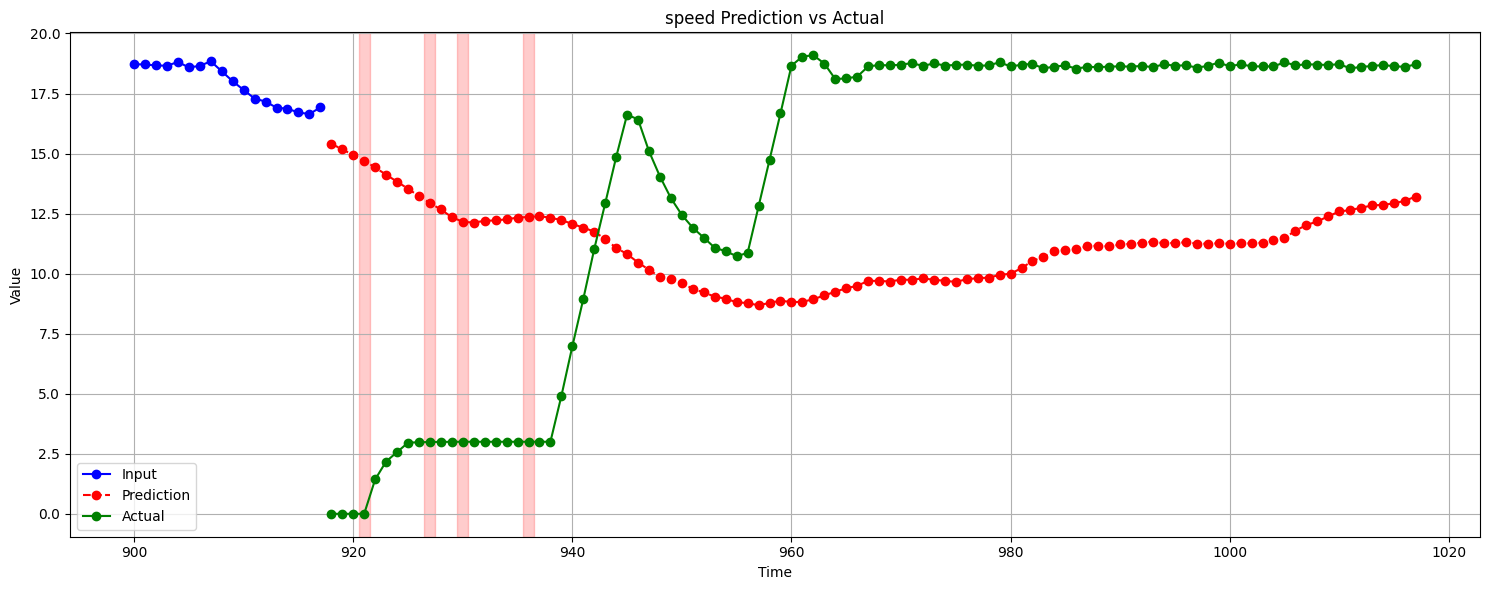


Metrics for Feature: speed
True Positives: 4
False Positives: 41
False Negatives: 0
True Negatives: 55
Probability of Detection (PD): 100.00%
False Alarm Rate (FAR): 42.71%
Anomaly Prob: 45/100 (0.45)


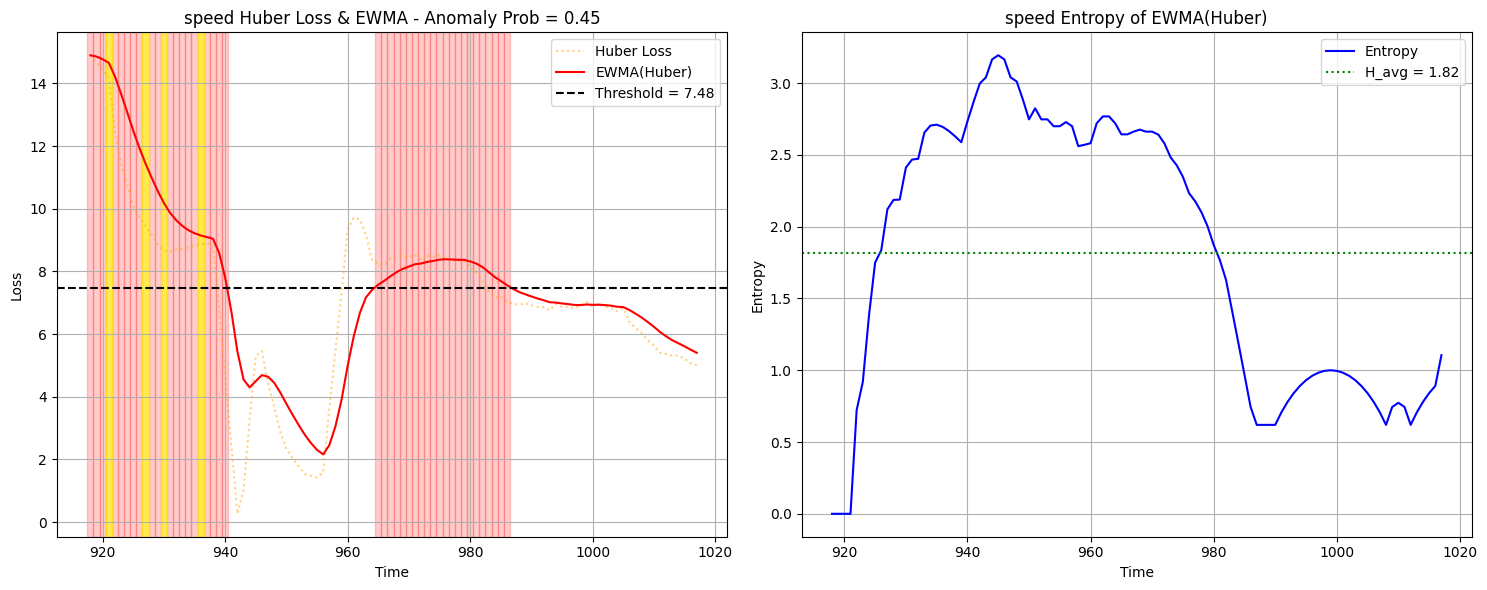

In [16]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, LSTM, 
                                     Dense, Reshape, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import matplotlib.pyplot as plt


def load_trained_model(input_shape, output_steps, n_features):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(output_steps * n_features),
        Reshape((output_steps, n_features))
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.load_weights("sequence_prediction_model.weights.h5")
    return model


def calculate_entropy(data):
    value_counts = np.bincount(data)
    probabilities = value_counts / np.sum(value_counts)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))


def dynthreshold(vectime, vecvalue):
    time_stamps = np.array(vectime)
    packets = np.array(vecvalue)
    packets_int = np.round(packets).astype(int)
    num_points = len(packets_int)

    window_size = 25
    entropy_values = np.array([
        calculate_entropy(packets_int[max(0, i - window_size):i + 1]) for i in range(num_points)
    ])
    H_avg = np.mean(entropy_values)
    sigma = np.std(entropy_values)
    a = 6
    T_1 = H_avg + a * sigma
    return entropy_values, T_1, H_avg


def plot_residuals(prediction, actual_continuation, feature_names, test_labels, time_sequence, look_back=18):
    if actual_continuation is None:
        print("Actual continuation is not available, cannot compute residuals.")
        return

    huber_fn = Huber(delta=1.0)

    def compute_ewma(series, alpha=0.2):
        ewma = np.zeros_like(series)
        ewma[0] = series[0]
        for t in range(1, len(series)):
            ewma[t] = alpha * series[t] + (1 - alpha) * ewma[t - 1]
        return ewma

    plot_times = time_sequence[look_back:look_back + len(prediction)]
    plt.figure(figsize=(15, 6))

    for i, feature in enumerate(feature_names):
        plt.subplot(len(feature_names), 2, 2 * i + 1)

        per_step_huber = np.array([
            huber_fn(actual_continuation[t:t+1, i], prediction[t:t+1, i]).numpy()
            for t in range(len(prediction))
        ])
        smoothed_huber = compute_ewma(per_step_huber)
        entropy_vals, T1, H_avg = dynthreshold(plot_times, smoothed_huber)
        anomalies = (smoothed_huber > T1).astype(int)


        for idx in np.where(anomalies == 1)[0]:
            plt.axvspan(plot_times[idx] - 0.5, plot_times[idx] + 0.5, color='red', alpha=0.2)

        true_anomalies_idx = np.where(test_labels[look_back:look_back + len(prediction)] == 1)[0]
        for idx in true_anomalies_idx:
            plt.axvspan(plot_times[idx] - 0.5, plot_times[idx] + 0.5, color='yellow', alpha=0.6)

        # Compute Detection Metrics
        y_true = test_labels[look_back:look_back + len(prediction)]
        y_pred = anomalies

        TP = np.sum((y_pred == 1) & (y_true == 1))
        FN = np.sum((y_pred == 0) & (y_true == 1))
        FP = np.sum((y_pred == 1) & (y_true == 0))
        TN = np.sum((y_pred == 0) & (y_true == 0))

        prob_detection = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0.0
        false_alarm_rate = (FP / (FP + TN)) * 100 if (FP + TN) > 0 else 0.0
        print(f"\nMetrics for Feature: {feature}")
        print(f"True Positives: {TP}")
        print(f"False Positives: {FP}")
        print(f"False Negatives: {FN}")
        print(f"True Negatives: {TN}")
        print(f"Probability of Detection (PD): {prob_detection:.2f}%")
        print(f"False Alarm Rate (FAR): {false_alarm_rate:.2f}%")

        num_anomalies = np.sum(y_pred == 1)
        total_points = len(y_pred)
        anomaly_probability = (num_anomalies / total_points) if total_points > 0 else 0.0

        print(f"Anomaly Prob: {num_anomalies}/{total_points} ({anomaly_probability:.2f})")

        # Plot residuals and thresholds
        plt.plot(plot_times, per_step_huber, label='Huber Loss', color='orange', linestyle='dotted', alpha=0.5)
        plt.plot(plot_times, smoothed_huber, label='EWMA(Huber)', color='red')
        plt.axhline(y=T1, color='black', linestyle='--', label=f'Threshold = {T1:.2f}')
        plt.title(f'{feature} Huber Loss & EWMA - Anomaly Prob = {anomaly_probability}')
        plt.xlabel('Time')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Plot Entropy in second subplot
        plt.subplot(len(feature_names), 2, 2 * i + 2)
        plt.plot(plot_times, entropy_vals, label='Entropy', color='blue')
        plt.axhline(y=H_avg, color='green', linestyle=':', label=f'H_avg = {H_avg:.2f}')
        plt.title(f'{feature} Entropy of EWMA(Huber)')
        plt.xlabel('Time')
        plt.ylabel('Entropy')
        plt.legend()
        plt.grid(True)

        # for idx in np.where(anomalies == 1)[0]:
        #     plt.axvspan(plot_times[idx] - 0.5, plot_times[idx] + 0.5, color='red', alpha=0.2)

    plt.tight_layout()
    plt.savefig('residuals_huber_entropy_anomalies.png')
    plt.show()



def test_single_sequence(model, input_sequence):
    input_seq = np.expand_dims(input_sequence, axis=0)
    prediction = model.predict(input_seq)[0]
    return prediction


def plot_test_results(input_sequence, prediction, actual_continuation, labels, feature_names, time_sequence):
    look_back = input_sequence.shape[0]
    look_forward = prediction.shape[0]
    full_times = time_sequence[:look_back + look_forward]

    plt.figure(figsize=(15, 6))

    for i, feature in enumerate(feature_names):
        plt.subplot(1, len(feature_names), i+1)

        plt.plot(full_times[:look_back], input_sequence[:, i], 'b-o', label='Input')
        plt.plot(full_times[look_back:look_back + look_forward], prediction[:, i], 'r--o', label='Prediction')

        if actual_continuation is not None:
            plt.plot(full_times[look_back:look_back + look_forward], actual_continuation[:, i], 'g-o', label='Actual')

        input_anomalies = np.where(labels[:look_back] == 1)[0]
        for idx in input_anomalies:
            plt.axvspan(full_times[idx] - 0.5, full_times[idx] + 0.5, color='red', alpha=0.2)

        continuation_anomalies = np.where(labels[look_back:look_back + look_forward] == 1)[0]
        for idx in continuation_anomalies:
            plt.axvspan(full_times[look_back + idx] - 0.5, full_times[look_back + idx] + 0.5, color='red', alpha=0.2)

        plt.title(f'{feature} Prediction vs Actual')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('prediction_vs_actual.png')
    plt.show()


if __name__ == "__main__":
    look_back = 18
    look_forward = 100
    n_features = 2

    # Fetch sequence
    time_sequence, full_features, full_labels = sequences[available_sequences[106]]

    test_features = full_features[-look_back:]
    test_labels = full_labels

    if len(full_features) >= look_back + look_forward:
        actual_continuation = full_features[look_back:look_back + look_forward]
    else:
        actual_continuation = None
        print("Warning: Not enough data points for actual continuation")

    if test_features.shape != (look_back, n_features):
        raise ValueError(f"Input sequence must have shape ({look_back}, {n_features}). Got {test_features.shape}")

    model = load_trained_model(
        input_shape=(look_back, n_features),
        output_steps=look_forward,
        n_features=n_features
    )

    prediction = test_single_sequence(model, test_features)

    print("Input Sequence Features:\n", test_features)
    print("\nInput Sequence Labels (0=normal, 1=anomaly):\n", test_labels)
    print("\nPredicted Next Steps:\n", prediction)

    if actual_continuation is not None:
        print("\nActual Next Steps:\n", actual_continuation)

    # Plot with real time axis
    plot_test_results(
        test_features,
        prediction,
        actual_continuation,
        np.concatenate([full_labels, np.zeros(look_forward)]),
        ['speed'],
        time_sequence
    )

    plot_residuals(
        prediction,
        actual_continuation,
        ['speed'],
        test_labels,
        time_sequence,
        look_back=look_back
    )


In [17]:
import time
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.losses import Huber

if __name__ == "__main__":
    look_back = 18
    look_forward = 100
    n_features = 2
    feature_names = ['speed']

    model = load_trained_model(
        input_shape=(look_back, n_features),
        output_steps=look_forward,
        n_features=n_features
    )

    pd_list = []
    far_list = []
    anomaly_score_list = []
    compute_times = []

    all_true_labels = []
    all_pred_anomalies = []

    for seq_name in available_sequences:
        time_sequence, full_features, full_labels = sequences[seq_name]

        if len(full_features) < (look_back + look_forward):
            print(f"Skipping {seq_name}: Not enough data")
            continue

        test_features = full_features[-(look_back + look_forward):-look_forward]
        actual_continuation = full_features[-look_forward:]
        test_labels = full_labels

        if test_features.shape != (look_back, n_features):
            print(f"Skipping {seq_name}: Invalid shape {test_features.shape}")
            continue

        start_time = time.time()
        prediction = test_single_sequence(model, test_features)
        elapsed_time = time.time() - start_time
        compute_times.append(elapsed_time)

        huber_fn = Huber(delta=1.0)

        def compute_ewma(series, alpha=0.2):
            ewma = np.zeros_like(series)
            ewma[0] = series[0]
            for t in range(1, len(series)):
                ewma[t] = alpha * series[t] + (1 - alpha) * ewma[t - 1]
            return ewma

        y_true = test_labels[look_back:look_back + look_forward]
        all_anomalies = []

        for i in range(n_features):
            per_step_huber = np.array([
                huber_fn(actual_continuation[t:t+1, i], prediction[t:t+1, i]).numpy()
                for t in range(len(prediction))
            ])
            smoothed_huber = compute_ewma(per_step_huber)
            entropy_vals, T1, H_avg = dynthreshold(
                time_sequence[look_back:look_back + look_forward],
                smoothed_huber
            )
            anomalies = (smoothed_huber > T1).astype(int)
            all_anomalies.append(anomalies)

        combined_anomalies = np.any(np.stack(all_anomalies, axis=1), axis=1).astype(int)

        TP = np.sum((combined_anomalies == 1) & (y_true == 1))
        FN = np.sum((combined_anomalies == 0) & (y_true == 1))
        FP = np.sum((combined_anomalies == 1) & (y_true == 0))
        TN = np.sum((combined_anomalies == 0) & (y_true == 0))

        PD = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0.0
        FAR = (FP / (FP + TN)) * 100 if (FP + TN) > 0 else 0.0
        anomaly_score = np.mean(combined_anomalies)

        pd_list.append(PD)
        far_list.append(FAR)
        anomaly_score_list.append(anomaly_score)

        all_true_labels.extend(y_true)
        all_pred_anomalies.extend(combined_anomalies)

        print(f"\n[{seq_name}] PD: {PD:.2f}%, FAR: {FAR:.2f}%, Anomaly Score: {anomaly_score:.2f}, Time: {elapsed_time:.4f}s")

    # Calculate final metrics
    f1 = f1_score(all_true_labels, all_pred_anomalies, zero_division=0)
    auc = roc_auc_score(all_true_labels, all_pred_anomalies) if len(set(all_true_labels)) > 1 else float('nan')

    print("\n===== METRICS ACROSS SEQUENCES =====")
    print(f"Median PD: {np.median(pd_list):.2f}%")
    print(f"Median FAR: {np.median(far_list):.2f}%")
    print(f"Median Anomaly Score: {np.median(anomaly_score_list):.2f}")
    print(f"Median Computation Time: {np.median(compute_times):.4f} seconds")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step

[('B', 895, 1)] PD: 25.00%, FAR: 63.10%, Anomaly Score: 0.57, Time: 0.1649s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

[('B', 895, 2)] PD: 60.00%, FAR: 46.32%, Anomaly Score: 0.47, Time: 0.0421s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[('B', 895, 3)] PD: 12.50%, FAR: 39.13%, Anomaly Score: 0.37, Time: 0.0439s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[('B', 895, 4)] PD: 14.29%, FAR: 67.74%, Anomaly Score: 0.64, Time: 0.0470s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

[('B', 895, 5)] PD: 30.77%, FAR: 55.17%, Anomaly Score: 0.52, Time: 0.0421s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

[('B', 895, 6)] PD: 15.38%, FAR: 21.84%, Anomaly Score: 0.21, Time: 0.0484s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

[('B', 895, 7)] PD: 0.00%, FAR: 12.77%, Anomaly Score: 0.12, Time: 0.0476s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

[('B', 895, 8)] PD: 75.00%, FAR: 44.57%, Anomaly Score: 0.47, Time: 0.0475s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[('B', 895, 9)] PD: 62.50%, FAR: 20.65%, 

In [8]:
import time

if __name__ == "__main__":
    look_back = 18
    look_forward = 100
    n_features = 2
    feature_names = ['speed']

    model = load_trained_model(
        input_shape=(look_back, n_features),
        output_steps=look_forward,
        n_features=n_features
    )

    pd_list = []
    far_list = []
    anomaly_score_list = []
    compute_times = []

    for seq_name in available_sequences:
        time_sequence, full_features, full_labels = sequences[seq_name]

        if len(full_features) < (look_back + look_forward):
            print(f"Skipping {seq_name}: Not enough data")
            continue

        test_features = full_features[-(look_back + look_forward):-look_forward]
        actual_continuation = full_features[-look_forward:]
        test_labels = full_labels

        if test_features.shape != (look_back, n_features):
            print(f"Skipping {seq_name}: Invalid shape {test_features.shape}")
            continue

        start_time = time.time()
        prediction = test_single_sequence(model, test_features)
        elapsed_time = time.time() - start_time
        compute_times.append(elapsed_time)

        # Collect metrics
        huber_fn = Huber(delta=1.0)

        def compute_ewma(series, alpha=0.2):
            ewma = np.zeros_like(series)
            ewma[0] = series[0]
            for t in range(1, len(series)):
                ewma[t] = alpha * series[t] + (1 - alpha) * ewma[t - 1]
            return ewma

        y_true = test_labels[look_back:look_back + look_forward]
        all_anomalies = []

        for i in range(n_features):
            per_step_huber = np.array([
                huber_fn(actual_continuation[t:t+1, i], prediction[t:t+1, i]).numpy()
                for t in range(len(prediction))
            ])
            smoothed_huber = compute_ewma(per_step_huber)
            entropy_vals, T1, H_avg = dynthreshold(
                time_sequence[look_back:look_back + look_forward],
                smoothed_huber
            )
            anomalies = (smoothed_huber > T1).astype(int)
            all_anomalies.append(anomalies)

        # Combine anomaly predictions across features
        combined_anomalies = np.any(np.stack(all_anomalies, axis=1), axis=1).astype(int)

        TP = np.sum((combined_anomalies == 1) & (y_true == 1))
        FN = np.sum((combined_anomalies == 0) & (y_true == 1))
        FP = np.sum((combined_anomalies == 1) & (y_true == 0))
        TN = np.sum((combined_anomalies == 0) & (y_true == 0))

        PD = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0.0
        FAR = (FP / (FP + TN)) * 100 if (FP + TN) > 0 else 0.0
        anomaly_score = np.mean(combined_anomalies)

        pd_list.append(PD)
        far_list.append(FAR)
        anomaly_score_list.append(anomaly_score)

        print(f"\n[{seq_name}] PD: {PD:.2f}%, FAR: {FAR:.2f}%, Anomaly Score: {anomaly_score:.2f}, Time: {elapsed_time:.4f}s")

    # Report averages
    print("\n===== AVERAGE METRICS ACROSS SEQUENCES =====")
    print(f"Average PD: {np.mean(pd_list):.2f}%")
    print(f"Average FAR: {np.mean(far_list):.2f}%")
    print(f"Average Anomaly Score: {np.mean(anomaly_score_list):.2f}")
    print(f"Average Computation Time: {np.mean(compute_times):.4f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step

[('C', 895, 1)] PD: 26.32%, FAR: 24.69%, Anomaly Score: 0.25, Time: 0.1903s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

[('C', 895, 2)] PD: 0.00%, FAR: 0.00%, Anomaly Score: 0.00, Time: 0.0409s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

[('C', 895, 3)] PD: 0.00%, FAR: 4.23%, Anomaly Score: 0.03, Time: 0.0393s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

[('C', 895, 4)] PD: 12.50%, FAR: 11.96%, Anomaly Score: 0.12, Time: 0.0387s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

[('C', 895, 5)] PD: 23.08%, FAR: 31.03%, Anomaly Score: 0.30, Time: 0.0558s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

[('C', 895, 6)] PD: 25.00%, FAR: 22.37%, Anomaly Score: 0.23, Time: 0.0523s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

[('C', 895, 7)] PD: 33.33%, FAR: 43.96%, Anomaly Score: 0.43, Time: 0.0457s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

[('C', 895, 8)] PD: 12.50%, FAR: 33.33%, Anomaly Score: 0.30, Time: 0.0440s
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

[('C', 895, 9)] PD: 21.88%, FAR: 20.59%, Ano

KeyboardInterrupt: 

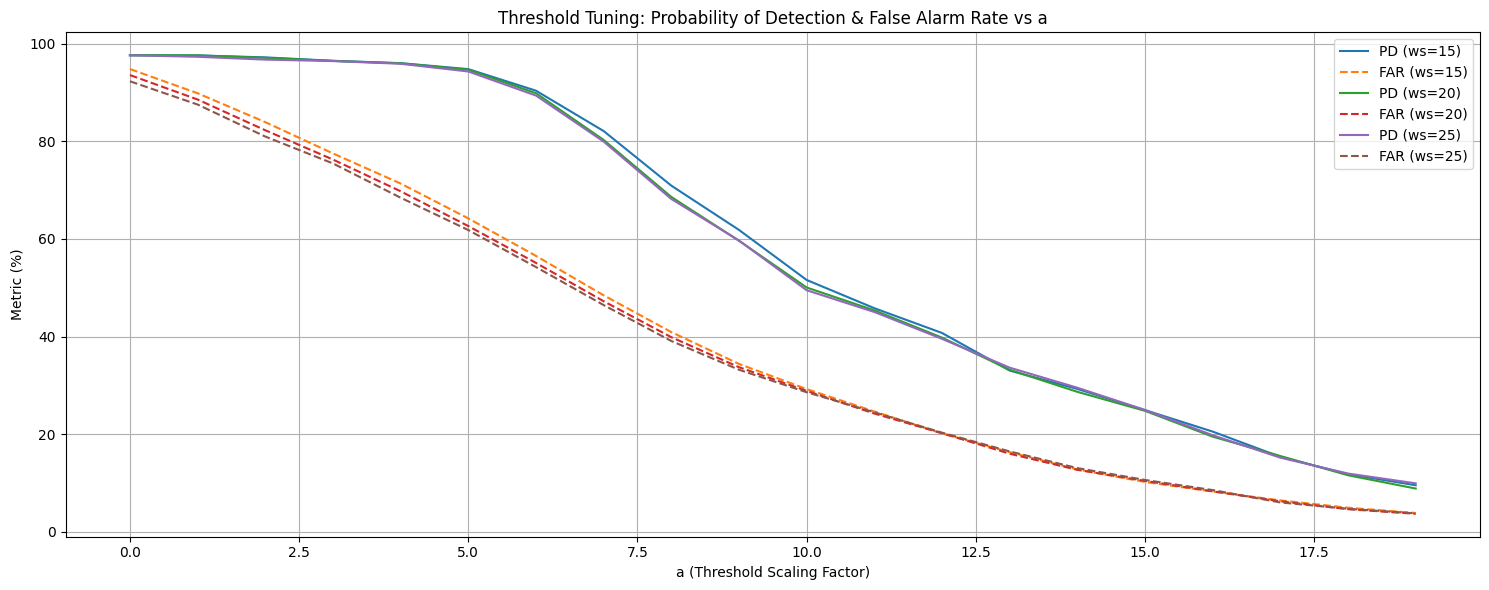

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Reshape, Input
from tensorflow.keras.optimizers import Adam
import random


def load_trained_model(input_shape, output_steps, n_features):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(64, return_sequences=True),
        LSTM(32),
        Dense(32, activation='relu'),
        Dense(output_steps * n_features),
        Reshape((output_steps, n_features))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    model.load_weights("sequence_prediction_model.weights.h5")
    return model

def calculate_entropy(data):
    value_counts = np.bincount(data)
    probabilities = value_counts / np.sum(value_counts)
    probabilities = probabilities[probabilities > 0]
    return -np.sum(probabilities * np.log2(probabilities))

def compute_ewma(series, alpha=0.2):
    ewma = np.zeros_like(series)
    ewma[0] = series[0]
    for t in range(1, len(series)):
        ewma[t] = alpha * series[t] + (1 - alpha) * ewma[t - 1]
    return ewma

def dynthreshold(vecvalue, a=10, window_size=15):
    packets = np.round(vecvalue).astype(int)
    num_points = len(packets)
    entropy_values = np.array([
        calculate_entropy(packets[max(0, i - window_size):i + 1]) for i in range(num_points)
    ])
    H_avg = np.mean(entropy_values)
    sigma = np.std(entropy_values)
    T_1 = H_avg + a * sigma
    return entropy_values, T_1, H_avg

def test_single_sequence(model, input_sequence):
    input_seq = np.expand_dims(input_sequence, axis=0)
    prediction = model.predict(input_seq, verbose=0)[0]
    return prediction

def evaluate_anomalies(prediction, actual, labels, a, window_size, look_back=18, feature_idx=0):
    huber = Huber(delta=1.0)
    huber_vals = np.array([
        huber(actual[t:t+1, feature_idx], prediction[t:t+1, feature_idx]).numpy()
        for t in range(len(prediction))
    ])
    smoothed = compute_ewma(huber_vals)
    entropy_vals, T1, _ = dynthreshold(smoothed, a=a, window_size=window_size)
    anomalies = (smoothed > T1).astype(int)
    y_true = labels[look_back:look_back + len(prediction)]

    TP = np.sum((anomalies == 1) & (y_true == 1))
    FN = np.sum((anomalies == 0) & (y_true == 1))
    FP = np.sum((anomalies == 1) & (y_true == 0))
    TN = np.sum((anomalies == 0) & (y_true == 0))

    PD = (TP / (TP + FN)) * 100 if (TP + FN) > 0 else 0.0
    FAR = (FP / (FP + TN)) * 100 if (FP + TN) > 0 else 0.0

    return PD, FAR

# Main
look_back = 18
look_forward = 100
n_features = 2
model = load_trained_model((look_back, n_features), look_forward, n_features)

a_range = range(0, 20)
window_sizes = [15, 20, 25] #[5, 10, 15, 20]

# Store metrics
metrics_dict = {ws: {'a': [], 'PD': [], 'FAR': []} for ws in window_sizes}
# a_seq = available_sequences[:30]

random.seed(42)
a_seq = available_sequences#random.sample(available_sequences, 100)


for window_size in window_sizes:
    for a in a_range:
        PD_total = 0
        FAR_total = 0
        valid_sequences = 0

        for seq_id in a_seq:
            time_sequence, full_features, full_labels = sequences[seq_id]

            if len(full_features) < look_back + look_forward:
                continue

            input_seq = full_features[-look_back:]
            actual_cont = full_features[look_back:look_back + look_forward]
            labels = full_labels

            if input_seq.shape != (look_back, n_features):
                continue

            prediction = test_single_sequence(model, input_seq)
            PD, FAR = evaluate_anomalies(prediction, actual_cont, labels, a, window_size, look_back=look_back)

            PD_total += PD
            FAR_total += FAR
            valid_sequences += 1

        if valid_sequences > 0:
            avg_PD = PD_total / valid_sequences
            avg_FAR = FAR_total / valid_sequences
            metrics_dict[window_size]['a'].append(a)
            metrics_dict[window_size]['PD'].append(avg_PD)
            metrics_dict[window_size]['FAR'].append(avg_FAR)

# Plotting
plt.figure(figsize=(15, 6))
for window_size in window_sizes:
    plt.plot(metrics_dict[window_size]['a'], metrics_dict[window_size]['PD'], label=f'PD (ws={window_size})')
    plt.plot(metrics_dict[window_size]['a'], metrics_dict[window_size]['FAR'], linestyle='--', label=f'FAR (ws={window_size})')

plt.title("Threshold Tuning: Probability of Detection & False Alarm Rate vs a")
plt.xlabel("a (Threshold Scaling Factor)")
plt.ylabel("Metric (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("threshold_tuning_results.png")
plt.show()


Best Youden's J: 35.15 at a=6, window_size=25


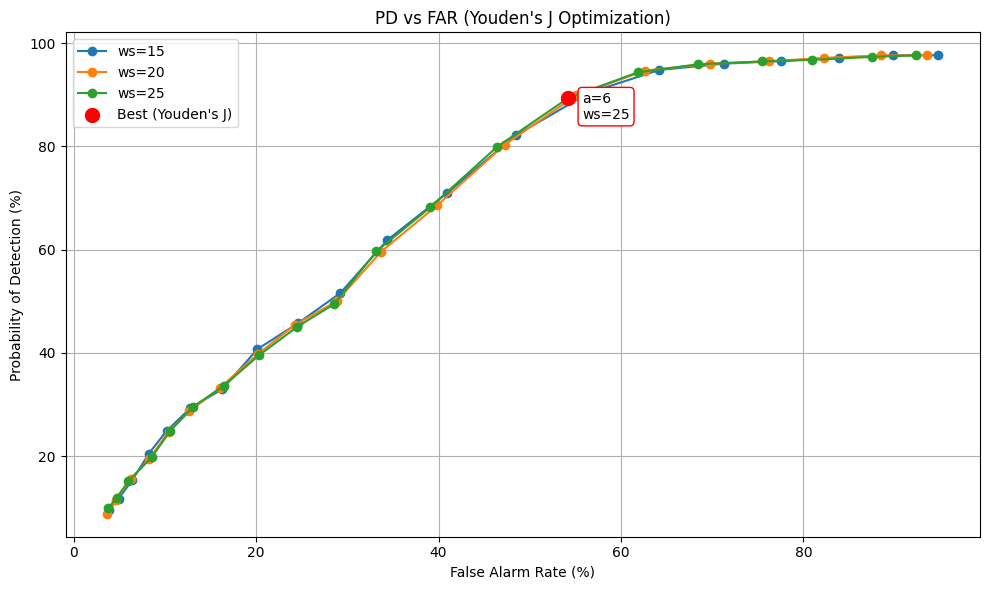

In [151]:
plt.figure(figsize=(10, 6))
max_j = -np.inf
best_point = None

for window_size in window_sizes:
    PDs = np.array(metrics_dict[window_size]['PD'])
    FARs = np.array(metrics_dict[window_size]['FAR'])
    a_vals = metrics_dict[window_size]['a']
    
    # Compute Youden's J statistic
    J_vals = PDs - FARs
    idx_best = np.argmax(J_vals)

    # Save best point
    if J_vals[idx_best] > max_j:
        max_j = J_vals[idx_best]
        best_point = {
            'window_size': window_size,
            'PD': PDs[idx_best],
            'FAR': FARs[idx_best],
            'a': a_vals[idx_best]
        }

    # Plot PD vs FAR
    plt.plot(FARs, PDs, marker='o', label=f'ws={window_size}')

# Annotate the best point
if best_point:
    plt.scatter(best_point['FAR'], best_point['PD'], color='red', s=100, zorder=5, label='Best (Youden\'s J)')
    plt.annotate(
        f"a={best_point['a']}\nws={best_point['window_size']}",
        (best_point['FAR'], best_point['PD']),
        textcoords="offset points", xytext=(10, -15), ha='left', fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='red', facecolor='white')
    )
    print(f"Best Youden's J: {max_j:.2f} at a={best_point['a']}, window_size={best_point['window_size']}")

plt.title("PD vs FAR (Youden's J Optimization)")
plt.xlabel("False Alarm Rate (%)")
plt.ylabel("Probability of Detection (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("pd_vs_far_youden.png")
plt.show()


In [154]:
# Step 1: Flatten all results into a list
all_results = []

for window_size in window_sizes:
    a_values = metrics_dict[window_size]['a']
    PDs = metrics_dict[window_size]['PD']
    FARs = metrics_dict[window_size]['FAR']

    for a_val, pd, far in zip(a_values, PDs, FARs):
        score = pd - far
        all_results.append({
            'window_size': window_size,
            'a': a_val,
            'PD': pd,
            'FAR': far,
            'score': score
        })

# Step 2: Sort all results by score descending
sorted_all_results = sorted(all_results, key=lambda x: x['score'], reverse=True)

# Step 3: Print top N results
top_n = 10
print(f"\nTop {top_n} 'a' values across all window sizes (sorted by score = PD - FAR):")
for i, res in enumerate(sorted_all_results[:top_n]):
    print(f"{i+1}. Window Size = {res['window_size']}, a = {res['a']}, "
          f"PD = {res['PD']:.2f}%, FAR = {res['FAR']:.2f}%, Score = {res['score']:.2f}")



Top 10 'a' values across all window sizes (sorted by score = PD - FAR):
1. Window Size = 25, a = 6, PD = 89.38%, FAR = 54.24%, Score = 35.15
2. Window Size = 20, a = 6, PD = 89.86%, FAR = 55.09%, Score = 34.78
3. Window Size = 15, a = 6, PD = 90.38%, FAR = 56.52%, Score = 33.86
4. Window Size = 15, a = 7, PD = 82.11%, FAR = 48.45%, Score = 33.66
5. Window Size = 25, a = 7, PD = 79.95%, FAR = 46.45%, Score = 33.51
6. Window Size = 20, a = 7, PD = 80.29%, FAR = 47.24%, Score = 33.05
7. Window Size = 25, a = 5, PD = 94.32%, FAR = 61.82%, Score = 32.49
8. Window Size = 20, a = 5, PD = 94.67%, FAR = 62.64%, Score = 32.03
9. Window Size = 15, a = 5, PD = 94.80%, FAR = 64.21%, Score = 30.59
10. Window Size = 15, a = 8, PD = 70.92%, FAR = 40.91%, Score = 30.01
